### Importe de librerias

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

# Redes Neuronales

Datasets a utilizar

In [2]:
#datasets normales
ds_train = pd.read_csv('properati_argentina_train.csv')
ds_test = pd.read_csv('properati_argentina_test.csv')

### Ingenieria de caracteristicas para datasets compelto

In [3]:
ds_train.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo
1,1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio
2,2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio
3,3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio
4,4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo


In [4]:
#dropeamos Unamed:0
ds_train.drop(columns=["Unnamed: 0"], inplace=True)
ds_test.drop(columns=["Unnamed: 0"], inplace=True)

#cambio nombre de columna precioxm2_relativo_q
ds_train.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)
ds_test.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)

Aplicamos dummies a la variable property_type

In [5]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)

ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

In [6]:
ds_train['tipo_precio'].unique()

array(['bajo', 'medio', 'alto'], dtype=object)

Tengo que pasar estas clases a numeros para que funcionen con clasificacion. Hago un label encoder

In [7]:
tipo_precio_replace = {'bajo':0, 'medio':1, 'alto':2}

ds_train.loc[:, 'tipo_precio'].replace(tipo_precio_replace, inplace=True)
ds_test.loc[:, 'tipo_precio'].replace(tipo_precio_replace, inplace=True)

In [8]:
ds_train.head()

,id,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,2.0,1.0,53.0,49.0,80000.0,0,1,0
1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,2.0,1.0,35.0,35.0,79900.0,1,1,0
2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,1.0,1.0,25.0,20.0,69000.0,1,1,0
3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,5.0,3.0,75.0,75.0,150000.0,1,1,0
4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,2.0,1.0,46.0,34.0,85000.0,0,1,0


In [9]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68012 entries, 0 to 68011
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          68012 non-null  object 
 1   latitud                     68012 non-null  float64
 2   longitud                    68012 non-null  float64
 3   property_rooms              68012 non-null  float64
 4   property_bedrooms           68012 non-null  float64
 5   property_surface_total      68012 non-null  float64
 6   property_surface_covered    68012 non-null  float64
 7   property_price              68012 non-null  float64
 8   tipo_precio                 68012 non-null  int64  
 9   property_type_Departamento  68012 non-null  uint8  
 10  property_type_PH            68012 non-null  uint8  
dtypes: float64(7), int64(1), object(1), uint8(2)
memory usage: 4.8+ MB


## Regresion

Funcion para graficar

In [10]:
features_regression = ['longitud', 'latitud', 'property_surface_total']
target_regression = ['property_price']

x_train_regress = ds_train.loc[:, features_regression]
x_test_regress = ds_test.loc[:, features_regression]
y_train_regress = ds_train.loc[:, target_regression]
y_test_regress = ds_test.loc[:, target_regression]

In [11]:
sscaler = StandardScaler()
sscaler.fit(x_train_regress)

StandardScaler()

In [12]:
x_train_regress = sscaler.transform(x_train_regress)
x_test_regress = sscaler.transform(x_test_regress)

#### Modelo de regresion

In [13]:
in_regress = len(features_regression)
out_regress = len(target_regression)

In [26]:
def regression_model_builder(hp):
    max_neurons = 50
    model = keras.Sequential()
    model.add(keras.Input(shape=(in_regress,)))
    
    hp_units_1 = hp.Int('units_1', min_value=1, max_value=max_neurons, step=1)
    hp_activation_1 = hp.Choice('activation_1', values=['tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, name="layer1"))
    
    hp_units_2 = hp.Int('units_2', min_value=1, max_value=max_neurons, step=1)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, name="layer2"))
    
    model.add(keras.layers.Dense(units=out_regress, name="output"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [27]:
regress_tuner = kt.RandomSearch(
    regression_model_builder,
    objective='val_loss',
    max_trials=20
)

In [28]:
regress_history = regress_tuner.search(x_train_regress, y_train_regress.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Trial 20 Complete [00h 00m 14s]
val_loss: 7561308672.0

Best val_loss So Far: 7561308672.0
Total elapsed time: 00h 05m 06s
INFO:tensorflow:Oracle triggered exit


In [31]:
best_regress_hps = regress_tuner.get_best_hyperparameters()[0]
print("Hiperparametros Optimos Encontrados")
print("  · Neuronas primera capa: ", best_regress_hps.get('units_1'))
print("  · Activavion primera capa: ", best_regress_hps.get('activation_1'))
print("  · Neuronas segunda capa: ", best_regress_hps.get('units_2'))
print("  · Activavion segunda capa: ", best_regress_hps.get('activation_2'))
print("  · Learning rate: ", best_regress_hps.get('learning_rate'))

Hiperparametros Optimos Encontrados
  · Neuronas primera capa:  15
  · Activavion primera capa:  tanh
  · Neuronas segunda capa:  8
  · Activavion segunda capa:  relu
  · Learning rate:  1e-06


In [14]:
regress_model = keras.Sequential(
    [
        keras.Input(shape=(in_regress,)),
        keras.layers.Dense(units=15, activation='tanh', name="layer1"),
        keras.layers.Dense(units=8, activation='relu', name="layer2"),
        keras.layers.Dense(units=out_regress, name="output")
    ]
)

In [15]:
regress_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 15)                60        
                                                                 
 layer2 (Dense)              (None, 8)                 128       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [16]:
regress_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-6),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [17]:
regress_model.fit(x_train_regress, y_train_regress.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 1s 4ms/step - loss: 19518799872.0000 - root_mean_squared_error: 139709.7031 - val_loss: 9362804736.0000 - val_root_mean_squared_error: 96761.5859
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 8515332096.0000 - root_mean_squared_error: 92278.5547 - val_loss: 8480037376.0000 - val_root_mean_squared_error: 92087.1250
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 8005599232.0000 - root_mean_squared_error: 89474.0156 - val_loss: 8446329856.0000 - val_root_mean_squared_error: 91903.9219
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 7614404096.0000 - root_mean_squared_error: 87260.5547 - val_loss: 7852894208.0000 - val_root_mean_squared_error: 88616.5625
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 7785158144.0000 - root_mean_squared_error: 88233.5469 - val_loss: 7900255744.0000 - val_root_mean_squared_error: 88883.3828
Epoch 6/100
7

In [18]:
y_pred_regress = regress_model.predict(x_test_regress)

532/532 [==============================] - 1s 868us/step


In [19]:
regress_rmse = mean_squared_error(
        y_true  = y_test_regress,
        y_pred  = y_pred_regress,
        squared = False
       )

print(f"La raiz del error cuadratico medio del test es: {regress_rmse:,.2f}")

La raiz del error cuadratico medio del test es: 82,059.13


###---

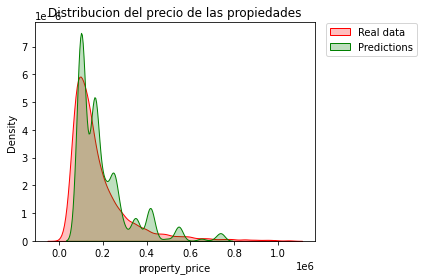

In [39]:
fig, ax = plt.subplots()
sns.kdeplot(data=y_test_regress.squeeze(), ax=ax, color='red', fill=True, label='Real data')
sns.kdeplot(data=y_pred_regress.squeeze(), ax=ax, color='green', fill=True, label='Predictions')
ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.title("Distribucion del precio de las propiedades")
plt.tight_layout()
plt.show()

## Clasificacion

In [10]:
ds_train.columns

Index(['id', 'latitud', 'longitud', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'tipo_precio', 'property_type_Departamento', 'property_type_PH'],
      dtype='object')

In [11]:
features_classification = ['longitud', 'latitud', 'property_rooms', 'property_bedrooms',
                           'property_surface_total', 'property_surface_covered',
                           'property_type_Departamento', 'property_type_PH']
target_classification = 'tipo_precio'

x_train_class = ds_train.loc[:, features_classification]
x_test_class = ds_test.loc[:, features_classification]
y_train_class = ds_train.loc[:, target_classification]
y_test_class = ds_test.loc[:, target_classification]

In [12]:
numeric_features = ['longitud', 'latitud', 'property_rooms', 'property_bedrooms',
                    'property_surface_total', 'property_surface_covered']

sscaler = StandardScaler()
sscaler.fit(x_train_class.loc[:, numeric_features])

StandardScaler()

In [13]:
x_train_class.loc[:, numeric_features] = sscaler.transform(x_train_class.loc[:, numeric_features])
x_test_class.loc[:, numeric_features] = sscaler.transform(x_test_class.loc[:, numeric_features])

#### Modelo de clasificacion

In [14]:
in_class = len(features_classification)
out_class = len(y_train_class.unique())

In [18]:
def classification_model_builder(hp):
    max_neurons = 50
    model = keras.Sequential()
    model.add(keras.Input(shape=(in_class,)))
    
    hp_units_1 = hp.Int('units_1', min_value=out_class, max_value=max_neurons, step=1)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid', 'softmax'])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, name="layer1"))
    
    hp_units_2 = hp.Int('units_2', min_value=out_class, max_value=max_neurons, step=1)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid', 'softmax'])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, name="layer2"))
    
    model.add(keras.layers.Dense(units=out_class, activation='softmax', name="output"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [20]:
class_tuner = kt.RandomSearch(
    classification_model_builder,
    objective='val_accuracy',
    max_trials=20
)

In [22]:
class_history = class_tuner.search(x_train_class, y_train_class.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Trial 20 Complete [00h 00m 18s]
val_accuracy: 0.5001837611198425

Best val_accuracy So Far: 0.5922958254814148
Total elapsed time: 00h 05m 27s
INFO:tensorflow:Oracle triggered exit


In [23]:
best_class_hps = class_tuner.get_best_hyperparameters()[0]
print("Hiperparametros Optimos Encontrados")
print("  · Neuronas primera capa: ", best_class_hps.get('units_1'))
print("  · Activavion primera capa: ", best_class_hps.get('activation_1'))
print("  · Neuronas segunda capa: ", best_class_hps.get('units_2'))
print("  · Activavion segunda capa: ", best_class_hps.get('activation_2'))
print("  · Learning rate: ", best_class_hps.get('learning_rate'))

Hiperparametros Optimos Encontrados
  · Neuronas primera capa:  21
  · Activavion primera capa:  tanh
  · Neuronas segunda capa:  30
  · Activavion segunda capa:  softmax
  · Learning rate:  0.1


In [24]:
class_model = keras.Sequential(
    [
        keras.Input(shape=(in_class,)),
        keras.layers.Dense(units=21, activation='tanh', name="layer1"),
        keras.layers.Dense(units=30, activation='softmax', name="layer2"),
        keras.layers.Dense(units=out_class, activation='softmax', name="output")
    ]
)

In [25]:
class_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 21)                189       
                                                                 
 layer2 (Dense)              (None, 30)                660       
                                                                 
 output (Dense)              (None, 3)                 93        
                                                                 
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________


In [26]:
class_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
class_model.fit(x_train_class, y_train_class.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 1s 3ms/step - loss: 1.0537 - accuracy: 0.4891 - val_loss: 1.0411 - val_accuracy: 0.5003
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 1.0403 - accuracy: 0.4997 - val_loss: 1.0389 - val_accuracy: 0.5003
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 1.0382 - accuracy: 0.4997 - val_loss: 1.0369 - val_accuracy: 0.5003
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 1.0361 - accuracy: 0.4997 - val_loss: 1.0348 - val_accuracy: 0.5003
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 1.0338 - accuracy: 0.4997 - val_loss: 1.0325 - val_accuracy: 0.5003
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 1.0313 - accuracy: 0.4997 - val_loss: 1.0300 - val_accuracy: 0.5003
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 1.0286 - accuracy: 0.4997 - val_loss: 1.0271 - val_accuracy: 0.5003
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8836 - accuracy: 0.5602 - val_loss: 0.8885 - val_accuracy: 0.5575
Epoch 60/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8825 - accuracy: 0.5624 - val_loss: 0.8872 - val_accuracy: 0.5582
Epoch 61/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8814 - accuracy: 0.5625 - val_loss: 0.8860 - val_accuracy: 0.5581
Epoch 62/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8802 - accuracy: 0.5641 - val_loss: 0.8847 - val_accuracy: 0.5587
Epoch 63/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8791 - accuracy: 0.5655 - val_loss: 0.8834 - val_accuracy: 0.5598
Epoch 64/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8780 - accuracy: 0.5650 - val_loss: 0.8820 - val_accuracy: 0.5630
Epoch 65/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8768 - accuracy: 0.5669 - val_loss: 0.8808 - val_accuracy: 0.5626
Epoch 

In [28]:
y_pred_class = class_model.predict(x_test_class)

532/532 [==============================] - 0s 708us/step


In [29]:
y_pred_class = np.argmax(y_pred_class ,axis = 1)

In [30]:
print("  Accuracy : %.2f" % accuracy_score(y_test_class.to_numpy(), y_pred_class))

  Accuracy : 0.60


TODO: otras metricas, mejorar matriz de confusion

<Figure size 2000x1000 with 0 Axes>

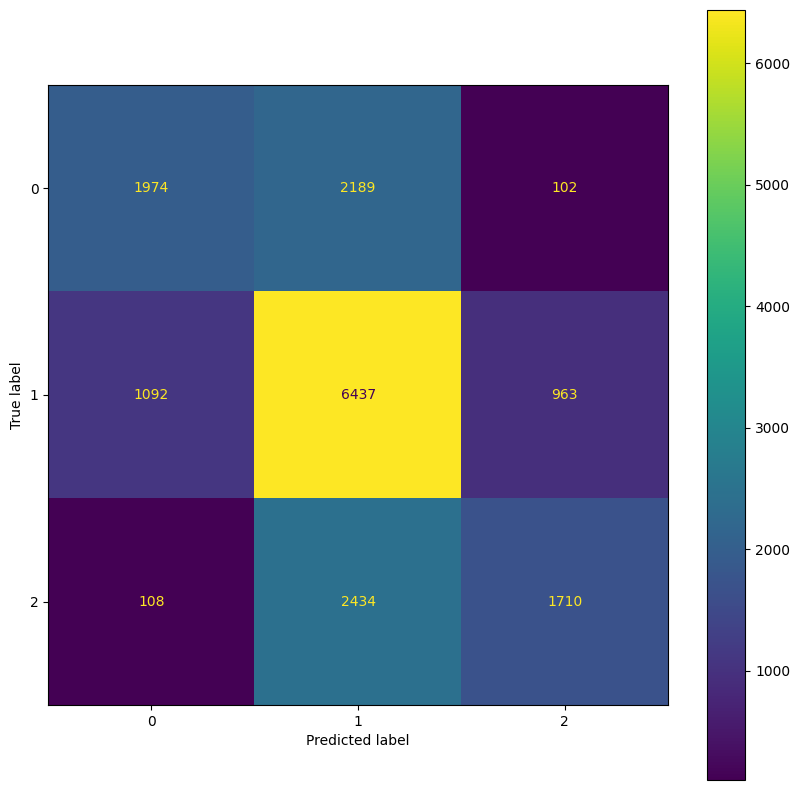

In [36]:
class_labels = ["bajo", "medio", "alto"]

plt.figure(figsize=(20,10))
cm = confusion_matrix(y_test_class.to_numpy(), y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
#ax.title.set_text(legend)
disp.plot(ax=ax)
plt.show()